# **Build Recomender System Using Matrix Factorizaion**

## **PRACTICAL 1**

### Load Movie Dataset 32M

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


In [ ]:
# Download the dataset
!wget -q "https://files.grouplens.org/datasets/movielens/ml-32m.zip"

# Extract the zip file
!unzip -o ml-32m.zip -d ml-32m


# Verify the contents
!ls -l ml-32m

Archive:  ml-32m.zip
   creating: ml-32m/ml-32m/
  inflating: ml-32m/ml-32m/tags.csv  
  inflating: ml-32m/ml-32m/links.csv  
  inflating: ml-32m/ml-32m/README.txt  
  inflating: ml-32m/ml-32m/checksums.txt  
  inflating: ml-32m/ml-32m/ratings.csv  
  inflating: ml-32m/ml-32m/movies.csv  
total 4
drwxrwxr-x 2 root root 4096 Oct 13  2023 ml-32m


In [ ]:
import csv
import numpy as np
# import pandas as pd

# Load data
print("Loading ratings...")
ratings = np.loadtxt(
    "ml-32m/ml-32m/ratings.csv",
    delimiter=",",
    skiprows=1,
    usecols=(0, 1, 2)
)

users = ratings[:, 0].astype(int)
movies = ratings[:, 1].astype(int)
scores = ratings[:, 2].astype(float)
# scores = pd.Series(scores)

print(f"Loaded {len(ratings):,} ratings")

Loading ratings...
Loaded 32,000,204 ratings


In [ ]:
ratings.shape

(32000204, 3)

In [ ]:
# Initialize the data structures
number_of_users = 0
userid_to_idx = {}
idx_to_userid = []
data_by_user = []

number_of_movies = 0
movieid_to_idx = {}
idx_to_movieid = []
data_by_movie = []

# Restructure the data
print("Building user and movie data structures...")

for user_id, movie_id, rating in zip(users, movies, scores): # iterate through multiple lists simultaneously
    # Handle user mapping
    if user_id not in userid_to_idx:
        idx_to_userid.append(user_id)
        userid_to_idx[user_id] = number_of_users
        number_of_users += 1
        data_by_user.append([])

    # Handle movie mapping
    if movie_id not in movieid_to_idx:
        idx_to_movieid.append(movie_id)
        movieid_to_idx[movie_id] = number_of_movies
        number_of_movies += 1
        data_by_movie.append([])

    # Convert rating to Python float
    user_idx = userid_to_idx[user_id]
    movie_idx = movieid_to_idx[movie_id]
    rating_float = float(rating)  # Convert to Python float

    data_by_user[user_idx].append((movie_idx, rating_float))
    data_by_movie[movie_idx].append((user_idx, rating_float))

print("Data restructuring complete!")
print(f"Total users: {number_of_users:,}")
print(f"Total movies: {number_of_movies:,}")

Building user and movie data structures...
Data restructuring complete!
Total users: 200,948
Total movies: 84,432


In [ ]:
# Test the structure
print(f"\nSample user data:")
sample_user_id = idx_to_userid[0]
sample_user_idx = userid_to_idx[sample_user_id]
print(f"User {sample_user_id} (idx {sample_user_idx}): {len(data_by_user[sample_user_idx])} ratings")
print(f"First few ratings: {data_by_user[sample_user_idx][:3]}")

print(f"\nSample movie data:")
sample_movie_id = idx_to_movieid[0]
sample_movie_idx = movieid_to_idx[sample_movie_id]
print(f"Movie {sample_movie_id} (idx {sample_movie_idx}): {len(data_by_movie[sample_movie_idx])} ratings")
print(f"First few ratings: {data_by_movie[sample_movie_idx][:3]}")


Sample user data:
User 1 (idx 0): 141 ratings
First few ratings: [(0, 4.0), (1, 1.0), (2, 2.0)]

Sample movie data:
Movie 17 (idx 0): 22251 ratings
First few ratings: [(0, 4.0), (2, 5.0), (14, 4.5)]


### **EDA**

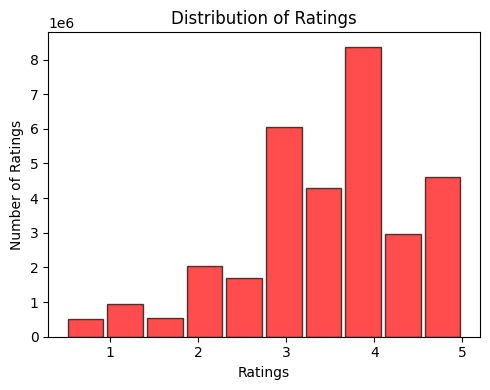

In [ ]:
# Basic rating distribution
plt.figure(figsize=(5, 4))
plt.hist(scores, bins=10, color='red', edgecolor='black', alpha=0.7, rwidth=0.9)
plt.title('Distribution of Ratings')
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")

plt.savefig("histogram.pdf", format="pdf")
# plt.show()

plt.tight_layout()
plt.show()

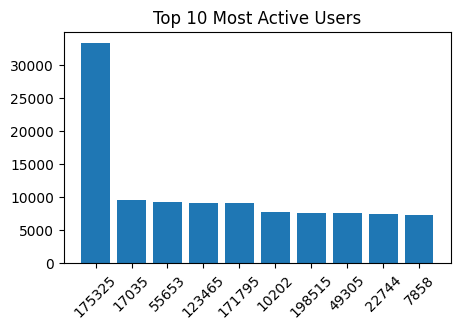

In [ ]:
# Ratings per user distribution
ratings_per_user = [len(ratings) for ratings in data_by_user]
plt.figure(figsize=(5, 3))

# plt.subplot(3, 1, 2)
# Top 10 most active users
user_activity = sorted([(i, len(ratings)) for i, ratings in enumerate(data_by_user)],
                       key=lambda x: x[1], reverse=True)[:10]
users, counts = zip(*user_activity)
plt.bar(range(10), counts)
plt.title('Top 10 Most Active Users')
plt.savefig("top10users.pdf", format="pdf")
plt.xticks(range(10), [idx_to_userid[u] for u in users], rotation=45)
plt.show()

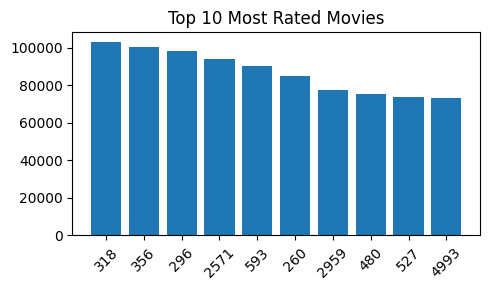

In [ ]:
# Ratings per movie distribution
ratings_per_movie = [len(ratings) for ratings in data_by_movie]
plt.figure(figsize=(5, 3))

# plt.subplot(3, 1, 2)
# Top 10 most rated movies
movie_popularity = sorted([(i, len(ratings)) for i, ratings in enumerate(data_by_movie)],
                         key=lambda x: x[1], reverse=True)[:10]
movies, counts = zip(*movie_popularity)
plt.bar(range(10), counts)
plt.title('Top 10 Most Rated Movies')
plt.savefig("top10movies.pdf", format="pdf")

plt.xticks(range(10), [idx_to_movieid[m] for m in movies], rotation=45)


plt.tight_layout()
plt.show()

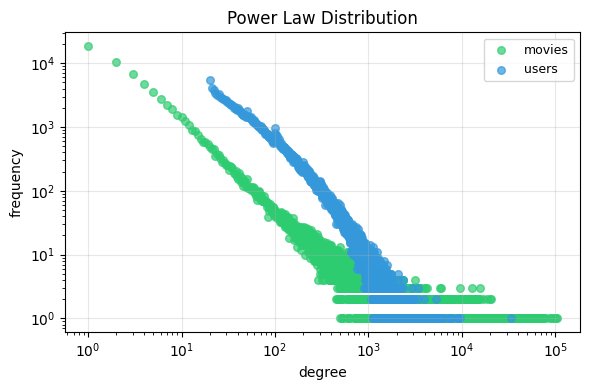

In [ ]:
# Compute degrees from restructured data
user_degrees = [len(r) for r in data_by_user]
movie_degrees = [len(r) for r in data_by_movie]

# Create plot
fig, ax = plt.subplots(figsize=(6, 4))  # Perfect size for Colab

# Plot both distributions
for degrees, color, label in [(movie_degrees, '#2ecc71', 'movies'),
                              (user_degrees, '#3498db', 'users')]:
    vals, freq = np.unique(degrees, return_counts=True)
    ax.scatter(vals, freq, c=color, s=30, alpha=0.7, label=label)
# Set scales and style
ax.set(xscale='log', yscale='log', xlabel='degree', ylabel='frequency',
       title='Power Law Distribution')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('powerlaw_colab.pdf')
plt.show()

## **PRACTICAL 2**

### Train Test Split

In [ ]:
# zip_file_small = ""

# url = f"https://files.grouplens.org/datasets/movielens/{zip_file_small}"

# download_dataset(url, zip_file_small)

In [ ]:
# Download the dataset
!wget -q "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

# Extract the zip file
!unzip -o ml-latest-small.zip -d ml-latest-small


# Verify the contents
!ls -l ml-latest-small

Archive:  ml-latest-small.zip
  inflating: ml-latest-small/ml-latest-small/links.csv  
  inflating: ml-latest-small/ml-latest-small/tags.csv  
  inflating: ml-latest-small/ml-latest-small/ratings.csv  
  inflating: ml-latest-small/ml-latest-small/README.txt  
  inflating: ml-latest-small/ml-latest-small/movies.csv  
total 4
drwxr-xr-x 2 root root 4096 Nov 23 12:24 ml-latest-small


In [ ]:
# # Download the dataset
# !wget -q "https://files.grouplens.org/datasets/movielens/10m.zip"

# # Extract the zip file
# !unzip -o ml-10m.zip -d ml-10m


# # Verify the contents
# !ls -l ml-10m

In [ ]:
import csv
import numpy as np
# import pandas as pd

# Load data
print("Loading ratings...")
ratings = np.loadtxt(
    "ml-latest-small/ml-latest-small/ratings.csv",
    delimiter=",",
    skiprows=1,
    usecols=(0, 1, 2)
)

users = ratings[:, 0].astype(int)
movies = ratings[:, 1].astype(int)
scores = ratings[:, 2].astype(float)
# scores = pd.Series(scores)

print(f"Loaded {len(ratings):,} ratings")

Loading ratings...
Loaded 100,836 ratings


In [ ]:
# Initialize the data structures
number_of_users = 0
userid_to_idx = {}
idx_to_userid = []
data_by_user = []

number_of_movies = 0
movieid_to_idx = {}
idx_to_movieid = []
data_by_movie = []

# Restructure the data
print("Building user and movie data structures...")

for user_id, movie_id, rating in zip(users, movies, scores): # iterate through multiple lists simultaneously
    # Handle user mapping
    if user_id not in userid_to_idx:
        idx_to_userid.append(user_id)
        userid_to_idx[user_id] = number_of_users
        number_of_users += 1
        data_by_user.append([])

    # Handle movie mapping
    if movie_id not in movieid_to_idx:
        idx_to_movieid.append(movie_id)
        movieid_to_idx[movie_id] = number_of_movies
        number_of_movies += 1
        data_by_movie.append([])

    # Convert rating to Python float
    user_idx = userid_to_idx[user_id]
    movie_idx = movieid_to_idx[movie_id]
    rating_float = float(rating)  # Convert to Python float

    data_by_user[user_idx].append((movie_idx, rating_float))
    data_by_movie[movie_idx].append((user_idx, rating_float))

print("Data restructuring complete!")
print(f"Total users: {number_of_users:,}")
print(f"Total movies: {number_of_movies:,}")

Building user and movie data structures...
Data restructuring complete!
Total users: 610
Total movies: 9,724


Creating leave-last-out split (like Netflix/KDD Cup) like Netflix/KDD Cup to preserve power laws

In [ ]:
# Use your sample data structures
n_users = len(data_by_user)
n_movies = len(data_by_movie)

# Initialize ONLY user data structures for split
data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]

np.random.seed(42)

print("Splitting user data (80-20)...")
# Split user data only
for i in range(n_users): # loop over all users
    tuples = data_by_user[i]
    for movie_idx, rating in tuples: # loop over all tuples
        if np.random.rand() < 0.8:  # 80% train, 20% test
            data_by_user_train[i].append((movie_idx, rating)) # add to train
        else:
            data_by_user_test[i].append((movie_idx, rating)) # add to test

print("Deriving movie data from user split...")
# Initialize movie data structures (derived from user split)
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

# Build movie data from the user split
for user_idx in range(n_users):
    # Add train ratings to movie data
    for movie_idx, rating in data_by_user_train[user_idx]:
        data_by_movie_train[movie_idx].append((user_idx, rating))

    # Add test ratings to movie data
    for movie_idx, rating in data_by_user_test[user_idx]:
        data_by_movie_test[movie_idx].append((user_idx, rating))

# Sort for efficient lookup
print("Sorting structures...")
for ratings in data_by_user_train: ratings.sort(key=lambda x: x[0])
for ratings in data_by_user_test: ratings.sort(key=lambda x: x[0])
for ratings in data_by_movie_train: ratings.sort(key=lambda x: x[0])
for ratings in data_by_movie_test: ratings.sort(key=lambda x: x[0])

print("Split completed!")

# Print shapes
print(f"\nTrain shapes:")
print(f"data_by_user_train: {len(data_by_user_train)} users")
print(f"data_by_movie_train: {len(data_by_movie_train)} movies")

print(f"\nTest shapes:")
print(f"data_by_user_test: {len(data_by_user_test)} users")
print(f"data_by_movie_test: {len(data_by_movie_test)} movies")

# Count total ratings
total_train_ratings = sum(len(ratings) for ratings in data_by_user_train)
total_test_ratings = sum(len(ratings) for ratings in data_by_user_test)
total_original_ratings = sum(len(ratings) for ratings in data_by_user)

print(f"\nTotal ratings:")
print(f"Original: {total_original_ratings:,}")
print(f"Train: {total_train_ratings:,} ({total_train_ratings/total_original_ratings*100:.1f}%)")
print(f"Test: {total_test_ratings:,} ({total_test_ratings/total_original_ratings*100:.1f}%)")

Splitting user data (80-20)...
Deriving movie data from user split...
Sorting structures...
Split completed!

Train shapes:
data_by_user_train: 610 users
data_by_movie_train: 9724 movies

Test shapes:
data_by_user_test: 610 users
data_by_movie_test: 9724 movies

Total ratings:
Original: 100,836
Train: 80,764 (80.1%)
Test: 20,072 (19.9%)



COMPREHENSIVE SPLIT VERIFICATION

COMPREHENSIVE VERIFICATION - USER DATA

1. SIZE VERIFICATION:
   Original: 100,836 ratings
   Train:    80,764 ratings (80.1%)
   Test:     20,072 ratings (19.9%)
   Integrity: True

2. ACTIVITY LEVEL DISTRIBUTION:
   Active users:
     Original: 610
     Train:    610
     Test:     610

3. POWER LAW PRESERVATION:
   Power law exponents:
     Original: α = 1.043
     Train:    α = 1.045
     Test:     α = 1.088
   Preservation: True

4. USER ACTIVITY PRESERVATION:
   Light users (≤ median):
     Original: 305
     Train:    375 (123.0% preserved)

5. TEST SET COVERAGE:
   Users with test ratings: 610/610 (100.0%)

6. RATING DISTRIBUTION:
   Average rating:
     Original: 3.502
     Train:    3.502
     Test:     3.499

COMPREHENSIVE VERIFICATION - MOVIE DATA

1. SIZE VERIFICATION:
   Original: 100,836 ratings
   Train:    80,764 ratings (80.1%)
   Test:     20,072 ratings (19.9%)
   Integrity: True

2. ACTIVITY LEVEL DISTRIBUTION:
   Active movies:
 

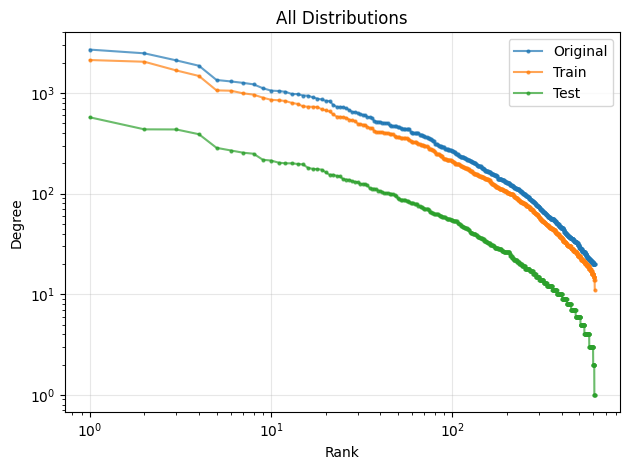


VERIFICATION COMPLETE!


In [ ]:
def verify_split_comprehensive(original_data, train_data, test_data, data_type="user"):
    """
    Comprehensive verification of train-test split
    """
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE VERIFICATION - {data_type.upper()} DATA")
    print(f"{'='*60}")

    # Basic statistics
    original_degrees = [len(ratings) for ratings in original_data if len(ratings) > 0]
    train_degrees = [len(ratings) for ratings in train_data if len(ratings) > 0]
    test_degrees = [len(ratings) for ratings in test_data if len(ratings) > 0]

    total_original = sum(len(ratings) for ratings in original_data)
    total_train = sum(len(ratings) for ratings in train_data)
    total_test = sum(len(ratings) for ratings in test_data)

    # 1. Size verification
    print(f"\n1. SIZE VERIFICATION:")
    print(f"   Original: {total_original:,} ratings")
    print(f"   Train:    {total_train:,} ratings ({total_train/total_original*100:.1f}%)")
    print(f"   Test:     {total_test:,} ratings ({total_test/total_original*100:.1f}%)")
    print(f"   Integrity: {total_original == total_train + total_test}")

    # 2. Activity level distribution
    print(f"\n2. ACTIVITY LEVEL DISTRIBUTION:")
    print(f"   Active {data_type}s:")
    print(f"     Original: {len(original_degrees):,}")
    print(f"     Train:    {len(train_degrees):,}")
    print(f"     Test:     {len(test_degrees):,}")

    # 3. Power law preservation
    print(f"\n3. POWER LAW PRESERVATION:")

    def calculate_power_law_exponent(degrees):
        if len(degrees) < 2:
            return 0
        # Simple power law estimation using log-log linear regression
        sorted_degrees = np.sort(degrees)[::-1]
        ranks = np.arange(1, len(sorted_degrees) + 1)

        # Filter zeros and take logs
        mask = (sorted_degrees > 0) & (ranks > 0)
        log_degrees = np.log(sorted_degrees[mask])
        log_ranks = np.log(ranks[mask])

        if len(log_degrees) > 1:
            slope, _, _, _, _ = scipy.stats.linregress(log_ranks, log_degrees)
            return -slope
        return 0

    try:
        import scipy.stats
        original_alpha = calculate_power_law_exponent(original_degrees)
        train_alpha = calculate_power_law_exponent(train_degrees)
        test_alpha = calculate_power_law_exponent(test_degrees)

        print(f"   Power law exponents:")
        print(f"     Original: α = {original_alpha:.3f}")
        print(f"     Train:    α = {train_alpha:.3f}")
        print(f"     Test:     α = {test_alpha:.3f}")
        print(f"   Preservation: {abs(train_alpha - original_alpha) < 0.1}")

    except ImportError:
        print("   (Install scipy for power law exponent calculation)")

    # 4. Heavy/light user analysis
    print(f"\n4. USER ACTIVITY PRESERVATION:")
    if len(original_degrees) > 0:
        median_original = np.median(original_degrees)

        heavy_users_original = sum(1 for d in original_degrees if d > median_original)
        heavy_users_train = sum(1 for d in train_degrees if d > median_original * 0.8)  # Allow some tolerance

        light_users_original = sum(1 for d in original_degrees if d <= median_original)
        light_users_train = sum(1 for d in train_degrees if d <= median_original * 1.2)  # Allow some tolerance

        # print(f"   Heavy {data_type}s (> median):")
        # print(f"     Original: {heavy_users_original:,}")
        # print(f"     Train:    {heavy_users_train:,} ({heavy_users_train/heavy_users_original*100:.1f}% preserved)")

        print(f"   Light {data_type}s (≤ median):")
        print(f"     Original: {light_users_original:,}")
        print(f"     Train:    {light_users_train:,} ({light_users_train/light_users_original*100:.1f}% preserved)")

    # 5. Test set coverage
    print(f"\n5. TEST SET COVERAGE:")
    users_with_test = sum(1 for ratings in test_data if len(ratings) > 0)
    print(f"   {data_type.capitalize()}s with test ratings: {users_with_test:,}/{len(original_data):,} ({users_with_test/len(original_data)*100:.1f}%)")

    # 6. Rating distribution
    print(f"\n6. RATING DISTRIBUTION:")
    def get_rating_distribution(data_list):
        all_ratings = []
        for ratings in data_list:
            for _, rating in ratings:
                all_ratings.append(rating)
        return all_ratings

    original_ratings = get_rating_distribution(original_data)
    train_ratings = get_rating_distribution(train_data)
    test_ratings = get_rating_distribution(test_data)

    if original_ratings:
        print(f"   Average rating:")
        print(f"     Original: {np.mean(original_ratings):.3f}")
        print(f"     Train:    {np.mean(train_ratings):.3f}")
        print(f"     Test:     {np.mean(test_ratings):.3f}")

def plot_power_law_comparison(original_data, train_data, test_data):
    """
    Plot power law distributions for visual comparison
    """
    try:
        import matplotlib.pyplot as plt

        original_degrees = [len(ratings) for ratings in original_data if len(ratings) > 0]
        train_degrees = [len(ratings) for ratings in train_data if len(ratings) > 0]
        test_degrees = [len(ratings) for ratings in test_data if len(ratings) > 0]

        # plt.figure(figsize=(12, 4))

        # # Plot 1: Original vs Train
        # plt.subplot(1, 3, 1)
        # for degrees, label, color in [(original_degrees, 'Original', 'blue'),
        #                             (train_degrees, 'Train', 'green')]:
        #     sorted_deg = np.sort(degrees)[::-1]
        #     ranks = np.arange(1, len(sorted_deg) + 1)
        #     plt.loglog(ranks, sorted_deg, 'o-', label=label, color=color, alpha=0.7, markersize=2)
        # plt.xlabel('Rank')
        # plt.ylabel('Degree')
        # plt.title('Original vs Train')
        # plt.legend()
        # plt.grid(True, alpha=0.3)

        # # Plot 2: Test distribution
        # plt.subplot(1, 3, 2)
        # if test_degrees:
        #     sorted_test = np.sort(test_degrees)[::-1]
        #     ranks_test = np.arange(1, len(sorted_test) + 1)
        #     plt.loglog(ranks_test, sorted_test, 'o-', color='red', alpha=0.7, markersize=2)
        # plt.xlabel('Rank')
        # plt.ylabel('Degree')
        # plt.title('Test Distribution')
        # plt.grid(True, alpha=0.3)

        # Plot 3: All three
        # plt.subplot(1, 3, 3)
        for degrees, label, color in [(original_degrees, 'Original', 'blue'),
                                    (train_degrees, 'Train', 'green'),
                                    (test_degrees, 'Test', 'red')]:
            if degrees:
                sorted_deg = np.sort(degrees)[::-1]
                ranks = np.arange(1, len(sorted_deg) + 1)
                plt.loglog(ranks, sorted_deg, 'o-', label=label, alpha=0.7, markersize=2)
        plt.xlabel('Rank')
        plt.ylabel('Degree')
        plt.title('All Distributions')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('power_law_split_comparison.pdf', dpi=300, bbox_inches='tight')
        plt.show()

    except ImportError:
        print("Matplotlib not available for plotting")

# Run comprehensive verification
print("\n" + "="*70)
print("COMPREHENSIVE SPLIT VERIFICATION")
print("="*70)

# Verify user data
verify_split_comprehensive(data_by_user, data_by_user_train, data_by_user_test, "user")

# Verify movie data
verify_split_comprehensive(data_by_movie, data_by_movie_train, data_by_movie_test, "movie")

# Plot power law comparison
print("\nGenerating power law comparison plots...")
plot_power_law_comparison(data_by_user, data_by_user_train, data_by_user_test)

print("\n" + "="*70)
print("VERIFICATION COMPLETE!")
print("="*70)

In [ ]:
# import numpy as np

# print("Creating improved leave-last-out split...")

# data_by_user_train = [[] for _ in range(n_users)]
# data_by_user_test = [[] for _ in range(n_users)]
# data_by_movie_train = [[] for _ in range(n_movies)]
# data_by_movie_test = [[] for _ in range(n_movies)]

# for user_idx in range(n_users):
#     ratings = sample_data_by_user[user_idx]

#     if len(ratings) > 0:
#         # More aggressive test set creation
#         if len(ratings) >= 20:
#             test_size = max(2, int(len(ratings) * 0.25))  # 25% for heavy users
#         elif len(ratings) >= 10:
#             test_size = max(2, int(len(ratings) * 0.3))   # 30% for medium users
#         elif len(ratings) >= 5:
#             test_size = 1  # 20% for light users
#         elif len(ratings) >= 2:
#             test_size = 1  # 50% for very light users
#         else:
#             test_size = 0  # Single rating users: all in train

#         if test_size > 0 and test_size < len(ratings):
#             data_by_user_train[user_idx] = ratings[:-test_size]
#             data_by_user_test[user_idx] = ratings[-test_size:]
#         else:
#             data_by_user_train[user_idx] = ratings
#             data_by_user_test[user_idx] = []

# print("Building movie data...")
# for user_idx in range(n_users):
#     for movie_idx, rating in data_by_user_train[user_idx]:
#         data_by_movie_train[movie_idx].append((user_idx, rating))
#     for movie_idx, rating in data_by_user_test[user_idx]:
#         data_by_movie_test[movie_idx].append((user_idx, rating))

# # Sort structures
# for ratings in data_by_user_train: ratings.sort(key=lambda x: x[0])
# for ratings in data_by_user_test: ratings.sort(key=lambda x: x[0])
# for ratings in data_by_movie_train: ratings.sort(key=lambda x: x[0])
# for ratings in data_by_movie_test: ratings.sort(key=lambda x: x[0])

# print("Improved split completed!")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats

# def verify_split_comprehensive(original_data, train_data, test_data, data_type="user"):
#     """
#     FIXED comprehensive verification with charts
#     """
#     print(f"\n{'='*60}")
#     print(f"COMPREHENSIVE VERIFICATION - {data_type.upper()} DATA")
#     print(f"{'='*60}")

#     # Basic statistics
#     original_degrees = [len(ratings) for ratings in original_data if len(ratings) > 0]
#     train_degrees = [len(ratings) for ratings in train_data if len(ratings) > 0]
#     test_degrees = [len(ratings) for ratings in test_data if len(ratings) > 0]

#     total_original = sum(len(ratings) for ratings in original_data)
#     total_train = sum(len(ratings) for ratings in train_data)
#     total_test = sum(len(ratings) for ratings in test_data)

#     # 1. Size verification
#     print(f"\n1. SIZE VERIFICATION:")
#     print(f"   Original: {total_original:,} ratings")
#     print(f"   Train:    {total_train:,} ratings ({total_train/total_original*100:.1f}%)")
#     print(f"   Test:     {total_test:,} ratings ({total_test/total_original*100:.1f}%)")
#     print(f"   Integrity: {total_original == total_train + total_test}")

#     # 2. Activity level distribution - FIXED
#     print(f"\n2. ACTIVITY LEVEL DISTRIBUTION:")
#     print(f"   Active {data_type}s:")
#     print(f"     Original: {len(original_degrees):,}")
#     print(f"     Train:    {len(train_degrees):,}")
#     print(f"     Test:     {len(test_degrees):,}")

#     # 3. Power law preservation
#     print(f"\n3. POWER LAW PRESERVATION:")

#     def calculate_power_law_exponent(degrees):
#         if len(degrees) < 2:
#             return 0
#         sorted_degrees = np.sort(degrees)[::-1]
#         ranks = np.arange(1, len(sorted_degrees) + 1)

#         mask = (sorted_degrees > 0) & (ranks > 0)
#         log_degrees = np.log(sorted_degrees[mask])
#         log_ranks = np.log(ranks[mask])

#         if len(log_degrees) > 1:
#             slope, _, _, _, _ = scipy.stats.linregress(log_ranks, log_degrees)
#             return -slope
#         return 0

#     original_alpha = calculate_power_law_exponent(original_degrees)
#     train_alpha = calculate_power_law_exponent(train_degrees)
#     test_alpha = calculate_power_law_exponent(test_degrees)

#     print(f"   Power law exponents:")
#     print(f"     Original: α = {original_alpha:.3f}")
#     print(f"     Train:    α = {train_alpha:.3f}")
#     print(f"     Test:     α = {test_alpha:.3f}")
#     print(f"   Preservation: {abs(train_alpha - original_alpha) < 0.1}")

#     # 4. Heavy/light analysis - FIXED
#     print(f"\n4. ACTIVITY PRESERVATION (FIXED):")
#     if len(original_degrees) > 0:
#         median_original = np.median(original_degrees)

#         heavy_users_original = sum(1 for d in original_degrees if d > median_original)
#         heavy_users_train = sum(1 for d in train_degrees if d > median_original)

#         light_users_original = sum(1 for d in original_degrees if d <= median_original)
#         light_users_train = sum(1 for d in train_degrees if d <= median_original)

#         print(f"   Heavy {data_type}s (> {median_original:.1f} ratings):")
#         print(f"     Original: {heavy_users_original:,}")
#         print(f"     Train:    {heavy_users_train:,}")
#         if heavy_users_original > 0:
#             print(f"     Preservation: {heavy_users_train/heavy_users_original*100:.1f}%")

#         print(f"   Light {data_type}s (≤ {median_original:.1f} ratings):")
#         print(f"     Original: {light_users_original:,}")
#         print(f"     Train:    {light_users_train:,}")
#         if light_users_original > 0:
#             print(f"     Preservation: {light_users_train/light_users_original*100:.1f}%")

#     # 5. Test set coverage
#     print(f"\n5. TEST SET COVERAGE:")
#     entities_with_test = sum(1 for ratings in test_data if len(ratings) > 0)
#     print(f"   {data_type.capitalize()}s with test ratings: {entities_with_test:,}/{len(original_data):,} ({entities_with_test/len(original_data)*100:.1f}%)")

#     # 6. Rating distribution
#     print(f"\n6. RATING DISTRIBUTION:")
#     def get_rating_stats(data_list):
#         all_ratings = []
#         for ratings in data_list:
#             for _, rating in ratings:
#                 all_ratings.append(rating)
#         return all_ratings

#     original_ratings = get_rating_stats(original_data)
#     train_ratings = get_rating_stats(train_data)
#     test_ratings = get_rating_stats(test_data)

#     if original_ratings:
#         print(f"   Average rating:")
#         print(f"     Original: {np.mean(original_ratings):.3f}")
#         print(f"     Train:    {np.mean(train_ratings):.3f}")
#         print(f"     Test:     {np.mean(test_ratings):.3f}")

# def plot_power_law_comparison(original_data, train_data, test_data, data_type="user"):
#     """
#     Plot power law distributions for visual comparison
#     """
#     original_degrees = [len(ratings) for ratings in original_data if len(ratings) > 0]
#     train_degrees = [len(ratings) for ratings in train_data if len(ratings) > 0]
#     test_degrees = [len(ratings) for ratings in test_data if len(ratings) > 0]

#     # Create figure with subplots
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
#     fig.suptitle(f'Power Law Distribution Analysis - {data_type.capitalize()} Data', fontsize=16, fontweight='bold')

#     # Plot 1: All distributions comparison
#     ax1 = axes[0, 0]
#     for degrees, label, color, marker in [
#         (original_degrees, 'Original', 'blue', 'o'),
#         (train_degrees, 'Train', 'green', 's'),
#         (test_degrees, 'Test', 'red', '^')
#     ]:
#         if len(degrees) > 0:
#             sorted_deg = np.sort(degrees)[::-1]
#             ranks = np.arange(1, len(sorted_deg) + 1)
#             ax1.loglog(ranks, sorted_deg, marker=marker, label=label, color=color,
#                       alpha=0.7, markersize=3, linewidth=1)

#     ax1.set_xlabel('Rank')
#     ax1.set_ylabel('Number of Ratings')
#     ax1.set_title(f'{data_type.capitalize()} Power Law Distributions')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)

#     # Plot 2: Original vs Train (zoomed)
#     ax2 = axes[0, 1]
#     for degrees, label, color in [(original_degrees, 'Original', 'blue'),
#                                  (train_degrees, 'Train', 'green')]:
#         if len(degrees) > 0:
#             sorted_deg = np.sort(degrees)[::-1]
#             ranks = np.arange(1, len(sorted_deg) + 1)
#             ax2.loglog(ranks, sorted_deg, 'o-', label=label, color=color, alpha=0.7, markersize=2)

#     ax2.set_xlabel('Rank')
#     ax2.set_ylabel('Number of Ratings')
#     ax2.set_title('Original vs Train (Preservation Check)')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)

#     # Plot 3: Histogram of degrees
#     ax3 = axes[1, 0]
#     bins = np.logspace(0, np.log10(max(original_degrees + train_degrees + test_degrees) + 1), 50)

#     ax3.hist(original_degrees, bins=bins, alpha=0.7, label='Original', color='blue', density=True)
#     ax3.hist(train_degrees, bins=bins, alpha=0.7, label='Train', color='green', density=True)
#     if test_degrees:
#         ax3.hist(test_degrees, bins=bins, alpha=0.7, label='Test', color='red', density=True)

#     ax3.set_xscale('log')
#     ax3.set_xlabel('Number of Ratings')
#     ax3.set_ylabel('Density')
#     ax3.set_title('Degree Distribution Histogram')
#     ax3.legend()
#     ax3.grid(True, alpha=0.3)

#     # Plot 4: Cumulative distribution
#     ax4 = axes[1, 1]
#     for degrees, label, color in [(original_degrees, 'Original', 'blue'),
#                                  (train_degrees, 'Train', 'green'),
#                                  (test_degrees, 'Test', 'red')]:
#         if len(degrees) > 0:
#             sorted_deg = np.sort(degrees)[::-1]
#             cumulative = np.cumsum(sorted_deg) / np.sum(sorted_deg)
#             ax4.plot(np.arange(len(sorted_deg)), cumulative, label=label, color=color, linewidth=2)

#     ax4.set_xlabel(f'{data_type.capitalize()} Rank')
#     ax4.set_ylabel('Cumulative Fraction of Ratings')
#     ax4.set_title('Cumulative Rating Distribution')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.savefig(f'power_law_{data_type}_comparison.png', dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_rating_distribution_comparison(original_data, train_data, test_data):
#     """
#     Plot rating value distributions
#     """
#     def get_all_ratings(data_list):
#         all_ratings = []
#         for ratings in data_list:
#             for _, rating in ratings:
#                 all_ratings.append(rating)
#         return all_ratings

#     original_ratings = get_all_ratings(original_data)
#     train_ratings = get_all_ratings(train_data)
#     test_ratings = get_all_ratings(test_data)

#     fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#     fig.suptitle('Rating Value Distribution Analysis', fontsize=16, fontweight='bold')

#     # Plot 1: Histogram of ratings
#     ax1 = axes[0]
#     bins = np.arange(0.5, 5.6, 0.5)

#     ax1.hist(original_ratings, bins=bins, alpha=0.7, label='Original', color='blue', density=True)
#     ax1.hist(train_ratings, bins=bins, alpha=0.7, label='Train', color='green', density=True)
#     ax1.hist(test_ratings, bins=bins, alpha=0.7, label='Test', color='red', density=True)

#     ax1.set_xlabel('Rating Value')
#     ax1.set_ylabel('Density')
#     ax1.set_title('Rating Distribution Histogram')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)

#     # Plot 2: Box plot of ratings
#     ax2 = axes[1]
#     rating_data = [original_ratings, train_ratings, test_ratings]
#     labels = ['Original', 'Train', 'Test']
#     colors = ['blue', 'green', 'red']

#     box_plots = ax2.boxplot(rating_data, labels=labels, patch_artist=True)
#     for patch, color in zip(box_plots['boxes'], colors):
#         patch.set_facecolor(color)
#         patch.set_alpha(0.7)

#     # Add mean values as text
#     for i, (ratings, label) in enumerate(zip(rating_data, labels)):
#         ax2.text(i + 1, np.mean(ratings) + 0.1, f'μ={np.mean(ratings):.2f}',
#                 ha='center', va='bottom', fontweight='bold')

#     plt.tight_layout()
#     plt.savefig('rating_distribution_comparison.png', dpi=300, bbox_inches='tight')
#     plt.show()

# # Run comprehensive verification with charts
# print("\n" + "="*70)
# print("FIXED COMPREHENSIVE VERIFICATION WITH CHARTS")
# print("="*70)

# # Verify user data
# verify_split_comprehensive(sample_data_by_user, data_by_user_train, data_by_user_test, "user")

# # Verify movie data
# verify_split_comprehensive(sample_data_by_movie, data_by_movie_train, data_by_movie_test, "movie")

# # Generate charts
# print("\n" + "="*70)
# print("GENERATING ANALYSIS CHARTS")
# print("="*70)

# print("1. Generating User Power Law Charts...")
# plot_power_law_comparison(sample_data_by_user, data_by_user_train, data_by_user_test, "user")

# print("2. Generating Movie Power Law Charts...")
# plot_power_law_comparison(sample_data_by_movie, data_by_movie_train, data_by_movie_test, "movie")

# print("3. Generating Rating Distribution Charts...")
# plot_rating_distribution_comparison(sample_data_by_user, data_by_user_train, data_by_user_test)

# print("\n" + "="*70)
# print("VERIFICATION COMPLETE!")
# print("="*70)
# print("Charts saved as:")
# print("  - power_law_user_comparison.png")
# print("  - power_law_movie_comparison.png")
# print("  - rating_distribution_comparison.png")

### Build Model

A Model with bias only


✅ Build a model that finds maximum likelihood estimate for user + item biases with alternating least squares

✅ Plot the loss function (negative log likelihood) over training iterations, using data_by_user_train. It should go down monotonically!
Note that if you plotted the loss function using data_by_movie_train, the answers would be the same

✅ Plot the root mean squared error over training iterations, using data_by_user_train. What does it converge to?

✅ Plot the root mean squared error for data_by_user_test after each training iteration. What does it converge to? Does it follow the training error?

### Bias Update
User Biases ($b_m$)

$$
b_m \leftarrow \frac{\lambda \sum_{n \in \Omega_m} (r_{mn} - b_n)}{\lambda |\Omega_m| + \tau}
$$


Item Biases ($b_n$)

$$
b_n \leftarrow \frac{\lambda \sum_{m \in \Omega_n} (r_{mn} - b_m)}{\lambda |\Omega_n| + \tau}
$$

In [ ]:
def update_biases(data_by_user, data_by_movie, user_biases, item_biases, lam, gamma):
    M = len(data_by_user)
    N = len(item_biases)

    # Update user biases
    for m in range(M):
        bias = 0
        item_counter = 0
        for n, r in data_by_user[m]:
            bias += lam * (r - item_biases[n])
            item_counter += 1
        if item_counter > 0:
            user_biases[m] = bias / (lam * item_counter + gamma)

    for n in range(N):
        bias = 0
        user_counter = 0
        for m, r in data_by_movie[n]:
            bias += lam * (r - user_biases[m])
            user_counter += 1
        if user_counter > 0:
            item_biases[n] = bias / (lam * user_counter + gamma)

    return user_biases, item_biases

### Loss function
$
L = \sum_{(m,n) \in \Omega} (r_{mn} - (b_m + b_n))^2 + \lambda \sum_{m} b_m^2 + \gamma \sum_{n} b_n^2
$

In [ ]:
def calculate_loss(data_by_user, user_biases, item_biases, lam, gamma):
    ss_error = 0
    count = 0


    # Reconstruction error term
    for user_idx, ratings in enumerate(data_by_user):
        for movie_idx, rating in ratings:
            predicted = user_biases[user_idx] + item_biases[movie_idx]
            residual = rating - predicted
            ss_error += residual ** 2
            count += 1

    # Regularization terms
    user_reg = np.sum(user_biases ** 2)
    item_reg = np.sum(item_biases ** 2)

    # Total loss
    loss = (lam / 2) * ss_error + (gamma / 2) * (user_reg + item_reg)

    return loss

### RMSE
$
\text{RMSE} = \sqrt{\frac{1}{m+n} \sum_{(m,n) \in \Omega} (r_{mn} - (b_m + b_n))^2}
$

In [ ]:
def calculate_rmse(data_by_user, user_biases, item_biases):
    total_error = 0
    count = 0

    for user_idx, ratings in enumerate(data_by_user):
        for movie_idx, rating in ratings:

            predicted = user_biases[user_idx] + item_biases[movie_idx]
            error = rating - predicted
            total_error += error ** 2
            count += 1

    rmse = np.sqrt(total_error / count)
    return rmse

### ALS Model Bias Only

In [ ]:
def run_als_model(train_data, test_data, lam, gamma, num_iterations=10):
    M = len(train_data)

    train_max = max(item_idx for user_ratings in train_data for item_idx, _ in user_ratings)
    test_max = max(item_idx for user_ratings in test_data for item_idx, _ in user_ratings)
    N = max(train_max, test_max) + 1

    user_biases = np.zeros(M)
    item_biases = np.zeros(N)

    train_rmse_history = []
    test_rmse_history = []
    loss_history = []

    for iteration in range(num_iterations):
        # Update biases using TRAIN data only
        user_biases, item_biases = update_biases(train_data, data_by_movie_train, user_biases, item_biases, lam, gamma)

        # Calculate metrics on TRAIN data
        train_rmse = calculate_rmse(train_data, user_biases, item_biases)
        loss = calculate_loss(train_data, user_biases, item_biases, lam, gamma)

        # Calculate metrics on TEST data
        test_rmse = calculate_rmse(test_data, user_biases, item_biases)

        train_rmse_history.append(train_rmse)
        test_rmse_history.append(test_rmse)
        loss_history.append(loss)

        print(f"Iteration {iteration+1}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}, Loss = {loss:.4f}")

    return user_biases, item_biases, train_rmse_history, test_rmse_history, loss_history

In [ ]:
def plot_metrics(train_rmse_history, test_rmse_history, loss_history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot RMSE
    ax1.plot(train_rmse_history, label='Train RMSE')
    ax1.plot(test_rmse_history, label='Test RMSE')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('RMSE')
    ax1.set_title('RMSE vs Iteration')
    plt.savefig("RSMSE.pdf", format="pdf")

    ax1.legend()
    ax1.grid(True)

    # Plot Loss
    ax2.plot(loss_history)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss vs Iteration')
    plt.savefig("loss.pdf", format="pdf")

    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
lam = 1.0      # lambda parameter
gamma = 0.01    # regularization parameter
num_iterations = 10

In [ ]:
# Run model
user_biases, item_biases, train_rmse_history, test_rmse_history, loss_history = run_als_model(
    data_by_user_train,
    data_by_user_test,
    lam,
    gamma,
    num_iterations
)



Iteration 1: Train RMSE = 0.7979, Test RMSE = 0.8898, Loss = 25775.4317
Iteration 2: Train RMSE = 0.7806, Test RMSE = 0.8779, Loss = 24674.8845
Iteration 3: Train RMSE = 0.7792, Test RMSE = 0.8787, Loss = 24590.4048
Iteration 4: Train RMSE = 0.7791, Test RMSE = 0.8794, Loss = 24581.7599
Iteration 5: Train RMSE = 0.7790, Test RMSE = 0.8797, Loss = 24580.5785
Iteration 6: Train RMSE = 0.7790, Test RMSE = 0.8798, Loss = 24580.3559
Iteration 7: Train RMSE = 0.7790, Test RMSE = 0.8798, Loss = 24580.2955
Iteration 8: Train RMSE = 0.7790, Test RMSE = 0.8799, Loss = 24580.2686
Iteration 9: Train RMSE = 0.7790, Test RMSE = 0.8799, Loss = 24580.2495
Iteration 10: Train RMSE = 0.7790, Test RMSE = 0.8799, Loss = 24580.2322


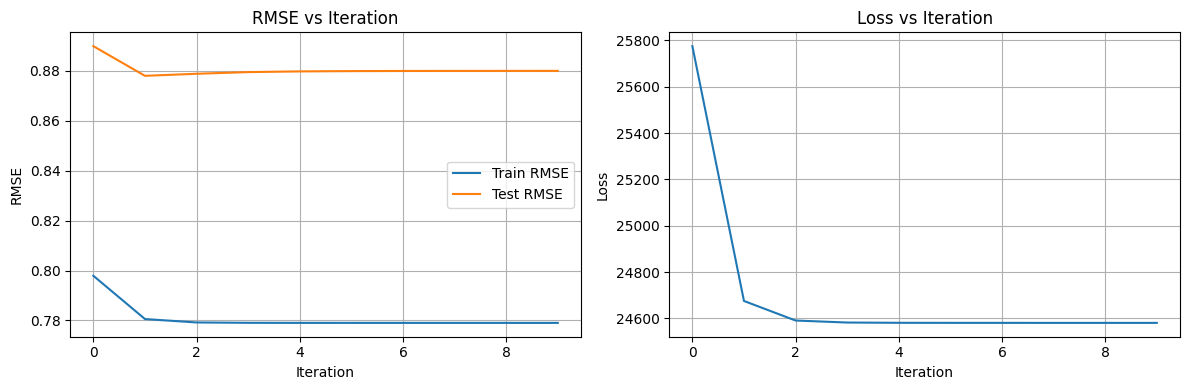

In [ ]:
# Plot
plot_metrics(train_rmse_history, test_rmse_history, loss_history)


## **PRACTICAL 3**

✅ Add user and item factors (latent trait vectors or matrices U and V)

✅ Add a sensible regularizer to your loss function

✅ Build a model that finds maximum likelihood estimate for user + item biases + latent trait vectors / factors with alternating least squares using *data_by_user_train* and *data_by_movie_train*

✅ Plot the loss function (negative log likelihood) over training iterations using data_by_user_train. It should go down monotonically!

✅ Plot the root mean squared error over training iterations using *data_by_user_train* and *data_by_user_test* . What does it converge to?

### Latent Factors and Bias Updates

User Factors ($\mathbf{u}_m$)

$$
\mathbf{u}_m \leftarrow \left( \lambda \sum_{n \in \Omega_m} \mathbf{v}_n \mathbf{v}_n^T + \tau I \right)^{-1} \left( \lambda \sum_{n \in \Omega_m} \mathbf{v}_n (r_{mn} - b_m - b_n) \right)
$$

User Biases ($b_m$)

$$
b_m \leftarrow \frac{\lambda \sum_{n \in \Omega_m} (r_{mn} - \mathbf{u}_m^T \mathbf{v}_n - b_n)}{\lambda |\Omega_m| + \tau}
$$

Item Factors ($\mathbf{v}_n$)

$$
\mathbf{v}_n \leftarrow \left( \lambda \sum_{m \in \Omega_n} \mathbf{u}_m \mathbf{u}_m^T + \tau I \right)^{-1} \left( \lambda \sum_{m \in \Omega_n} \mathbf{u}_m (r_{mn} - b_m - b_n) \right)
$$

Item Biases ($b_n$)

$$
b_n \leftarrow \frac{\lambda \sum_{m \in \Omega_n} (r_{mn} - \mathbf{u}_m^T \mathbf{v}_n - b_m)}{\lambda |\Omega_n| + \tau}
$$


In [ ]:
def update_biases_and_factors(data_by_user, data_by_movie, user_biases, item_biases, U, V, lam, gamma_b, gamma_u, gamma_v, K):
    M = len(data_by_user)
    N = len(item_biases)

    # Update user biases and user factors
    for m in range(M):
        # Update user bias
        bias_sum = 0
        count = 0
        for n, r in data_by_user[m]:
            bias_sum += lam * (r - item_biases[n] - np.dot(U[m], V[n]))
            count += 1
        if count > 0:
            user_biases[m] = bias_sum / (lam * count + gamma_b)

        # Update user factor vector
        A = np.zeros((K, K)) #store: λ Σ v_n v_n^T + τI
        b = np.zeros(K)      #store: λ Σ v_n (residual)
        for n, r in data_by_user[m]:
            residual = r - user_biases[m] - item_biases[n] # (r_mn - b_m^(u) - b_n^(i))
            A += np.outer(V[n], V[n]) # Σ v_n v_n^T
            b += residual * V[n]  #Σ v_n (residual)
        A = lam * A + gamma_u * np.eye(K) #λ Σ v_n v_n^T + τI  adds regularization to the diagonal
        b = lam * b
        U[m] = np.linalg.solve(A, b)

    # Update item biases and item factors
    for n in range(N):
        # Update item bias
        bias_sum = 0
        count = 0
        for m, r in data_by_movie[n]:
            bias_sum += lam * (r - user_biases[m] - np.dot(U[m], V[n]))
            count += 1
        if count > 0:
            item_biases[n] = bias_sum / (lam * count + gamma_b)

        # Update item factor vector
        A = np.zeros((K, K))
        b = np.zeros(K)
        for m, r in data_by_movie[n]:
            residual = r - user_biases[m] - item_biases[n]
            A += np.outer(U[m], U[m])
            b += residual * U[m]
        A = lam * A + gamma_v * np.eye(K)
        b = lam * b
        V[n] = np.linalg.solve(A, b)

    return user_biases, item_biases, U, V

### Loss function

In [ ]:
def calculate_loss(data_by_user, user_biases, item_biases, U, V, lam, gamma_b, gamma_u, gamma_v):
    ss_error = 0
    count = 0

    # Reconstruction error term
    for user_idx, ratings in enumerate(data_by_user):
        for movie_idx, rating in ratings:
            predicted = user_biases[user_idx] + item_biases[movie_idx] + np.dot(U[user_idx], V[movie_idx])
            residual = rating - predicted
            ss_error += residual ** 2
            count += 1

    # Regularization terms
    bias_reg = np.sum(user_biases ** 2) + np.sum(item_biases ** 2)
    user_factor_reg = np.sum(U ** 2)
    item_factor_reg = np.sum(V ** 2)

    # Total loss
    loss = (lam / 2) * ss_error + (gamma_b / 2) * bias_reg + (gamma_u / 2) * user_factor_reg + (gamma_v / 2) * item_factor_reg

    return loss

### RMSE

In [ ]:
def calculate_rmse(data_by_user, user_biases, item_biases, U, V):
    total_error = 0
    count = 0

    for user_idx, ratings in enumerate(data_by_user):
        for movie_idx, rating in ratings:
            predicted = user_biases[user_idx] + item_biases[movie_idx] + np.dot(U[user_idx], V[movie_idx])
            error = rating - predicted
            total_error += error ** 2
            count += 1

    rmse = np.sqrt(total_error / count)
    return rmse

### ALS Model Factors and Bias

In [ ]:
def run_als_model(train_data, test_data, lam, gamma_b, gamma_u, gamma_v, K, num_iterations=10):
    M = len(train_data)

    train_max = max(item_idx for user_ratings in train_data for item_idx, _ in user_ratings)
    test_max = max(item_idx for user_ratings in test_data for item_idx, _ in user_ratings)
    N = max(train_max, test_max) + 1

    user_biases = np.zeros(M)
    item_biases = np.zeros(N)
    U = np.random.randn(M, K) * 0.01
    V = np.random.randn(N, K) * 0.01

    # train_data_by_item = create_data_by_item(train_data, N)

    train_rmse_history = []
    test_rmse_history = []
    loss_history = []

    for iteration in range(num_iterations):
        user_biases, item_biases, U, V = update_biases_and_factors(train_data, data_by_movie_train, user_biases, item_biases, U, V, lam, gamma_b, gamma_u, gamma_v, K)

        train_rmse = calculate_rmse(train_data, user_biases, item_biases, U, V)
        loss = calculate_loss(train_data, user_biases, item_biases, U, V, lam, gamma_b, gamma_u, gamma_v)
        test_rmse = calculate_rmse(test_data, user_biases, item_biases, U, V)

        train_rmse_history.append(train_rmse)
        test_rmse_history.append(test_rmse)
        loss_history.append(loss)

        print(f"Iteration {iteration+1}: Train RMSE = {train_rmse:.4f}, Test RMSE = {test_rmse:.4f}, Loss = {loss:.4f}")

    return user_biases, item_biases, U, V, train_rmse_history, test_rmse_history, loss_history

In [ ]:
lam = 1.0           # lambda for reconstruction error
gamma_b = 0.01       # regularization for biases
gamma_u = 0.4       # regularization for user factors
gamma_v = 0.4       # regularization for item factors
K = 2             # number of latent factors
num_iterations = 7

In [ ]:
user_biases, item_biases, U, V, train_rmse_history, test_rmse_history, loss_history = run_als_model(
    data_by_user_train,
    data_by_user_test,
    lam,
    gamma_b,
    gamma_u,
    gamma_v,
    K,
    num_iterations
)



Iteration 1: Train RMSE = 0.8545, Test RMSE = 0.8730, Loss = 9369918.5297
Iteration 2: Train RMSE = 0.8118, Test RMSE = 0.8391, Loss = 8497587.7081
Iteration 3: Train RMSE = 0.7992, Test RMSE = 0.8279, Loss = 8249340.5279
Iteration 4: Train RMSE = 0.7936, Test RMSE = 0.8226, Loss = 8138331.5958
Iteration 5: Train RMSE = 0.7906, Test RMSE = 0.8199, Loss = 8079776.9678
Iteration 6: Train RMSE = 0.7891, Test RMSE = 0.8185, Loss = 8048380.2477
Iteration 7: Train RMSE = 0.7883, Test RMSE = 0.8178, Loss = 8029765.9306


NameError: name 'plot_metrics' is not defined

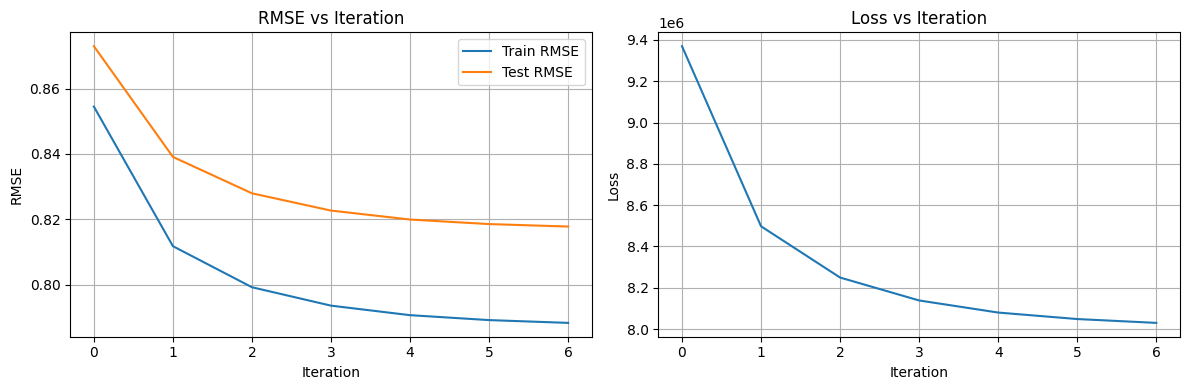

In [ ]:
plot_metrics(train_rmse_history, test_rmse_history, loss_history)

2 dimensional embedding, keep in mind the bias.

[link text](https://)Package like numbr
to reduce time to two seconds through optimization
Start with figures,
equations
then texts